# **Milestone 2 - Fingerprint Processing**

This section contains tasks that will help you get familiar with the basics of fingerprint processing.

You may add more code and markdown cells as needed

## TASK 1
* Load the Fingerprint Image `datasets\task3\1.tiff`
* Display it using `plt.imshow()`
* Load the Fingerprint Image `datasets\task3\2.tiff`
* Display it using `plt.imshow()`

#### Load the Fingerprint Image `datasets\task3\1.tiff`

In [188]:
## Hint: use opencv
import cv2 as cv
import matplotlib.pyplot as plt
img=cv.imread(r'datasets/task3/1.tiff')




#### Display the Fingerprint image

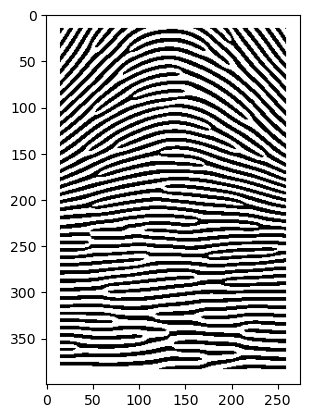

In [189]:
## Hint: use matplotlib
plt.imshow(img)


#### Load the Fingerprint Image `datasets\task3\2.tiff`

In [190]:
## Hint: use opencv
img2=cv.imread(r'datasets/task3/2.tiff')


#### Display the Second Fingerprint image

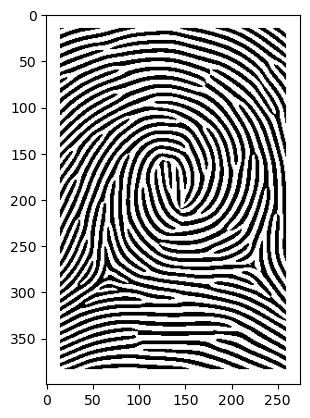

In [191]:
## Hint: use matplotlib
plt.imshow(img2)


## TASK 2
* Extract the minutia points from the fingerprint images
* Display the minutia vectors

Hint: Each minutiae vector will have the following format: 
> `[x, y, theta, type]` where `type` is `0` for ridge ending and `1` for ridge bifurcation

#### Extract the minutia vectors from the fingerprint images of `TASK 1` as a list of vectors

In [ ]:
## Hint: use any library you can find from anywhere (but mention the source here in the notebook as a comment)
# !pip install fingerprint_enhancer

import fingerprint_enhancer
# !pip install fingerprint-feature-extractor
# import fingerprint_feature_extractor
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from numpy import array

def filter_mask(img):
  # Calculate the local gradient (using Sobel filters)
  gx, gy = cv.Sobel(img, cv.CV_32F, 1, 0), cv.Sobel(img, cv.CV_32F, 0, 1)
  # Calculate the magnitude of the gradient for each pixel
  gx2, gy2 = gx**2, gy**2
  gm = np.sqrt(gx2 + gy2)
  # Integral over a square window
  sum_gm = cv.boxFilter(gm, -1, (25, 25), normalize = False)
  # Use a simple threshold for segmenting the fingerprint pattern
  thr = sum_gm.max() * 0.2
  mask = cv.threshold(sum_gm, thr, 255, cv.THRESH_BINARY)[1].astype(np.uint8)
  # A 1-pixel background border is added to the mask before computing the distance transform
  mask_distance = cv.distanceTransform(cv.copyMakeBorder(mask, 1, 1, 1, 1, cv.BORDER_CONSTANT), cv.DIST_C, 3)[1:-1,1:-1]
  return mask_distance


In [192]:
def enhancer(img):
  enhanced = fingerprint_enhancer.enhance_Fingerprint(img)		# enhance the fingerprint image
  # plt.imshow(enhanced)
  return enhanced

In [193]:
def convert_to_3d(img):
  res=np.empty([img.shape[0],img.shape[1],3])
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i,j]==0:
        res[i,j]=[255,255,255]
      else:
        res[i,j]=[0,0,0]
  # plt.imshow(res)
  return res

In [194]:
def binarize(img):
  _,bin = cv.threshold(img, 100, 255, cv.THRESH_BINARY)
  # plt.imshow(cv.cvtColor(res, cv.COLOR_RGB2BGR))
  return bin

def skeletonize(img):
  skeleton = cv.ximgproc.thinning(img, thinningType = cv.ximgproc.THINNING_GUOHALL)
  # plt.imshow(cv.cvtColor(skeleton, cv.COLOR_RGB2BGR))
  return skeleton

In [196]:
def compute_crossing_number(values):
    return np.count_nonzero(values < np.roll(values, -1))

In [197]:
# Create a filter that converts any 8-neighborhood into the corresponding byte value [0,255]
cn_filter = np.array([[  1,  2,  4],
                      [128,  0,  8],
                      [ 64, 32, 16]
                    ])
# Create a lookup table that maps each byte value to the corresponding crossing number
all_8_neighborhoods = [np.array([int(d) for d in f'{x:08b}'])[::-1] for x in range(256)]
cn_lut = np.array([compute_crossing_number(x) for x in all_8_neighborhoods]).astype(np.uint8)
def minutiae_generator(skeleton):
  # Skeleton: from 0/255 to 0/1 values
  skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
  # Apply the filter to encode the 8-neighborhood of each pixel into a byte [0,255]
  cn_values = cv.filter2D(skeleton01, -1, cn_filter, borderType = cv.BORDER_CONSTANT)
  # Apply the lookup table to obtain the crossing number of each pixel
  cn = cv.LUT(cn_values, cn_lut)
  # Keep only crossing numbers on the skeleton
  cn[skeleton==0] = 0

  # crossing number == 1 --> Termination, crossing number == 3 --> Bifurcation
  minutiae = [(x,y,cn[y,x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))]

  return minutiae

In [198]:
def compute_next_ridge_following_directions(previous_direction, values):    
    next_positions = np.argwhere(values!=0).ravel().tolist()
    if len(next_positions) > 0 and previous_direction != 8:
        # There is a previous direction: return all the next directions, sorted according to the distance from it,
        #                                except the direction, if any, that corresponds to the previous position
        next_positions.sort(key = lambda d: 4 - abs(abs(d - previous_direction) - 4))
        if next_positions[-1] == (previous_direction + 4) % 8: # the direction of the previous position is the opposite one
            next_positions = next_positions[:-1] # removes it
    return next_positions

In [199]:
import math
r2 = 2**0.5 # sqrt(2)

# The eight possible (x, y) offsets with each corresponding Euclidean distance
xy_steps = [(-1,-1,r2),( 0,-1,1),( 1,-1,r2),( 1, 0,1),( 1, 1,r2),( 0, 1,1),(-1, 1,r2),(-1, 0,1)]

nd_lut = [[compute_next_ridge_following_directions(pd, x) for pd in range(9)] for x in all_8_neighborhoods]

In [200]:
def follow_ridge_and_compute_angle(x, y,cn_values,skeleton, d = 8):
    px, py = x, y
    length = 0.0
    # Apply the lookup table to obtain the crossing number of each pixel
    cn = cv.LUT(cn_values, cn_lut)
    # Keep only crossing numbers on the skeleton
    cn[skeleton==0] = 0
    while length < 20: # max length followed
        next_directions = nd_lut[cn_values[py,px]][d]
        if len(next_directions) == 0:
            break
        # Need to check ALL possible next directions
        if (any(cn[py + xy_steps[nd][1], px + xy_steps[nd][0]] != 2 for nd in next_directions)):
            break # another minutia found: we stop here
        # Only the first direction has to be followed
        d = next_directions[0]
        ox, oy, l = xy_steps[d]
        px += ox ; py += oy ; length += l
    # check if the minimum length for a valid direction has been reached
    return math.atan2(-py+y, px-x) if length >= 10 else None

In [201]:
# Utilities for angle arithmetics
def angle_abs_difference(a, b):
    return math.pi - abs(abs(a - b) - math.pi)

def angle_mean(a, b):
    return math.atan2((math.sin(a)+math.sin(b))/2, ((math.cos(a)+math.cos(b))/2))

In [202]:
def minutiae_angles(minutiae, skeleton):
  minutiae_angle = []
  # Skeleton: from 0/255 to 0/1 values
  skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
  # Apply the filter to encode the 8-neighborhood of each pixel into a byte [0,255]
  cn_values = cv.filter2D(skeleton01, -1, cn_filter, borderType = cv.BORDER_CONSTANT)
  for x, y, term in minutiae:
      d = None
      if term: # termination: simply follow and compute the direction        
          d = follow_ridge_and_compute_angle(x, y, cn_values, skeleton)
      else: # bifurcation: follow each of the three branches
          dirs = nd_lut[cn_values[y,x]][8] # 8 means: no previous direction
          if len(dirs)==3: # only if there are exactly three branches
              angles = [follow_ridge_and_compute_angle(x+xy_steps[d][0], y+xy_steps[d][1],cn_values,skeleton, d) for d in dirs]
              if all(a is not None for a in angles):
                  a1, a2 = min(((angles[i], angles[(i+1)%3]) for i in range(3)), key=lambda t: angle_abs_difference(t[0], t[1]))
                  d = angle_mean(a1, a2)                
      if d is not None:
          minutiae_angle.append( (x, y, term, d) )
  return minutiae_angle

#### Display the minutia vectors

In [203]:
## Hint: Each minutiae vector will have the following format: 
## [x, y, theta, type] where type is 0 for ridge ending and 1 for ridge bifurcation
# im = cv.imread('102_7.tif',cv.IMREAD_GRAYSCALE) 

img1 = skeletonize(binarize(enhancer(img)))
minutiae_pts_arr = minutiae_generator(img1)
mask = filter_mask(img1)
filtered_minutiae = list(filter(lambda m: mask[m[1], m[0]]>20, minutiae_pts_arr))
minutiae_angle = minutiae_angles(filtered_minutiae, img1)
# print(minutiae_angle)
# plt.imshow(img)

In [204]:

imgg = skeletonize(binarize(enhancer(img2)))
minutiae_pts_arr = minutiae_generator(imgg)
mask = filter_mask(imgg)
filtered_minutiae = list(filter(lambda m: mask[m[1], m[0]]>20, minutiae_pts_arr))
minutiae_angle2 = minutiae_angles(filtered_minutiae, imgg)

## TASK 3
* Display the minutia vectors on the fingerprint images

#### Display the minutia vectors from `TASK 2` on the fingerprint images of `TASK 1`

In [ ]:
# Utility function to draw a set of minutiae over an image
def draw_minutiae(fingerprint, minutiae, termination_color = (255,0,0), bifurcation_color = (0,0,255)):
    print(fingerprint.shape)
    # res = cv.cvtColor(fingerprint, cv.COLOR_GRAY2BGR)
    res=fingerprint
    for x, y, t, *d in minutiae:
        color = termination_color if t else bifurcation_color
        if len(d)==0:
            z=x
            # cv.drawMarker(res, (x,y), color, cv.MARKER_SQUARE, 5)
        # else:
        #     cv.drawMarker(res, (x,y), color, cv.MARKER_CROSS, 1)
        else:
            if t:
                 cv.circle(res, (x,y), 5, color, 1)
            else:
                cv.drawMarker(res, (x,y), color, cv.MARKER_SQUARE, 14)

            
               
            # cv.rectangle(res, (x,y), color, 3, cv.LINE_AA)
            # cv.line(res, (x,y), (x+ox,y-oy), color, 3, cv.LINE_AA)
                
    return res

(400, 275, 3)


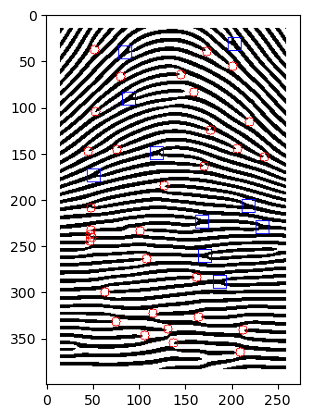

In [205]:
## Hint: use matplotlib and stacked images to show the results
## Use red circle for ridge ending and blue square for ridge bifurcation
im=draw_minutiae(img, minutiae_angle, termination_color = (255,0,0), bifurcation_color = (0,0,255))
plt.imshow(im)



(400, 275, 3)


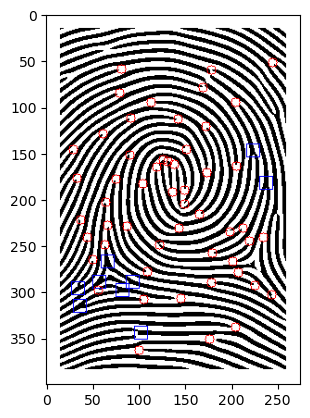

In [207]:
im2=draw_minutiae(img2, minutiae_angle2, termination_color = (255,0,0), bifurcation_color = (0,0,255))
plt.imshow(im2)